# Experiments with the CPAC_S01_S02_S03_05_31_20 dataset

## Libraries

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re
import warnings

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

from IPython.display import display, Markdown

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC_S01_S02_S03_05_31_20/CPAC10S_S01_S02_S03_06_01_20.csv")
df_orig.describe()

M_Trial_Num         M_Mass  M_Mass_to_L5S1  M_sub_task_indices  \
count  596920.000000  596920.000000   450392.000000       596920.000000   
mean       68.172854      10.576766        0.310355          295.212494   
std        23.458992       5.960748        0.164044          234.100540   
min         1.000000       0.000000        0.083662            1.000000   
25%        49.000000       5.000000        0.154197          121.000000   
50%        78.000000      10.000000        0.274311          250.000000   
75%        85.000000      15.000000        0.457227          407.000000   
max        96.000000      23.000000        0.701759         1866.000000   

       M_sub_task_num  M_include_overall        M_Index          M_Sub  \
count   596920.000000      596920.000000  596920.000000  596920.000000   
mean         5.496341           0.782267    2850.599620       1.897787   
std          4.754427           0.412705    2708.406675       0.817537   
min          1.000000           0.000000       1.000000       1.000000   
25%          1.000000           1.000000     603.000000       1.000000   
50%          4.000000           1.000000    1954.000000       2.000000   
75%          8.000000           1.000000    4445.000000       3.000000   
max         21.000000           1.000000   14119.000000       3.000000   

       M_sub_task_num_overall  M_Index_overall  ...  \
count           596920.000000    596920.000000  ...   
mean               235.306545     76305.094906  ...   
std                121.308144     72015.333181  ...   
min                  1.000000        -0.195016  ...   
25%                132.000000         0.000000  ...   
50%                250.000000     63184.500000  ...   
75%                335.000000    137799.250000  ...   
max                452.000000    233105.000000  ...   

       RWEO_03_04_00_00_INSOLE_LY_AP_threshF50_mm  \
count                               509406.000000   
mean                                   121.034549   
std                                     55.562888   
min                                      0.000000   
25%                                     75.000000   
50%                                    112.680000   
75%                                    168.120000   
max                                    242.320000   

       RWEO_01_00_00_00_INSOLE_RFORCE_threshF50_N  \
count                               594981.000000   
mean                                   357.312319   
std                                    283.629719   
min                                      0.000000   
25%                                    125.815000   
50%                                    313.860000   
75%                                    559.535000   
max                                   1558.065000   

       RWEO_01_02_00_00_INSOLE_RX_ML_threshF50_mm  \
count                               506937.000000   
mean                                    47.795679   
std                                      8.805979   
min                                      0.000000   
25%                                     44.110000   
50%                                     49.980000   
75%                                     53.710000   
max                                     71.260000   

       RWEO_01_02_00_00_INSOLE_RY_AP_threshF50_mm  \
count                               506937.000000   
mean                                   135.603684   
std                                     53.366872   
min                                      0.000000   
25%                                     93.770000   
50%                                    133.750000   
75%                                    183.140000   
max                                    247.560000   

       RWEF_03_00_00_00_INSOLE_LFORCE_threshF50_BW  \
count                                594981.000000   
mean                                      0.473457   
std                                       0.336114   
min                                       

## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")    

## Clean-up dataset

- Remove samples based on `M_include_overall`

In [4]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df['M_Trial_Name'].unique())} (before clean-up: {len(df_orig['M_Trial_Name'].unique())})")
print(f"Number of subjects: {len(df['M_Sub'].unique())}")

Number of samples: 466951 (before clean-up: 596920)
Number of trials: 140 (before clean-up: 141)
Number of subjects: 3


## Predictor configurations (recipes)

In [5]:
def predictor_short_name(predictor):
    return predictor[17:]

def predictor_sensor_number(predictor):
    return int(predictor[5:7])

def filter_predictors(all_predictors, patterns):
    if isinstance(patterns, str):
        patterns = (patterns,)
        
    predictors = []
    for predictor in all_predictors:
        for pattern in patterns:
            if pattern in predictor:
                predictors.append(predictor)
                break
    return predictors


feature_sets = {
    "Recipe 1: Simulated Wearable - All Regular": 
        filter_predictors(df.columns, "SWRF"),
    
    "Recipe 2: Simulated Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("SWRF", "SWEF")),
    
    "Recipe 3: Real Wearable - All Regular": 
        filter_predictors(df.columns, "RWRF"),
    
    "Recipe 4: Real Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("RWRF", "RWEF")),
    
    "Recipe 5: Real Wearable - Insole Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00")
        ),
    
    "Recipe 6: Real Wearable - Trunk Orientatoin Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("12_00_00_00",)
        ),
    
    "Recipe 7: Real Wearable - Insole & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00")
        ),
    
    "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00",
             "05_06_00_00", "05_09_00_00", "06_00_00_00", "09_00_00_00", "05_12_00_00", "05_06_01_03", "05_09_01_03")
        ),
    
}

for feature_set_name, predictors in feature_sets.items():
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")

Recipe 1: Simulated Wearable - All Regular
	Predictors: 75, Sensors: 10

Recipe 2: Simulated Wearable - All Regular & Exploratory
	Predictors: 104, Sensors: 10

Recipe 3: Real Wearable - All Regular
	Predictors: 166, Sensors: 10

Recipe 4: Real Wearable - All Regular & Exploratory
	Predictors: 201, Sensors: 10

Recipe 5: Real Wearable - Insole Only
	Predictors: 17, Sensors: 2

Recipe 6: Real Wearable - Trunk Orientatoin Only
	Predictors: 56, Sensors: 1

Recipe 7: Real Wearable - Insole & Trunk Orientation
	Predictors: 77, Sensors: 3

Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
	Predictors: 133, Sensors: 6



## Train/Test configurations

In [6]:
test_selectors = {
    "Subject 1 & 2 -> Subject 3": df["M_Sub"] == 3,
    "Subject 1 & 3 -> Subject 2": df["M_Sub"] == 2,
    "Subject 2 & 3 -> Subject 1": df["M_Sub"] == 1,
    "Subject 1 & 2 & 3 -> 5kg Test": df["M_Trial_Name"].str.match("S0[0-9]_5kg")
}

train_test_sets = {}
for test_selector_name, test_selector in test_selectors.items():
    #df_train, df_test = df[~test_selector].dropna(), df[test_selector].dropna()
    df_train, df_test = df[~test_selector], df[test_selector]
    train_test_sets[test_selector_name] = (df_train, df_test)
    print(f"{test_selector_name}: {len(df_train)}/{len(df_test)} "
          f"({len(df_train) / len(df):.1%}/{len(df_test) / len(df):.1%})")

Subject 1 & 2 -> Subject 3: 317564/149387 (68.0%/32.0%)
Subject 1 & 3 -> Subject 2: 308407/158544 (66.0%/34.0%)
Subject 2 & 3 -> Subject 1: 307931/159020 (65.9%/34.1%)
Subject 1 & 2 & 3 -> 5kg Test: 424084/42867 (90.8%/9.2%)


## Train and evaluate boosted tree models

In [7]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor())
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(desc, model, X_test, y_test, show_plot=False, show_importance=False):
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    rmse = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
    r2 = metrics.r2_score(y_test_pred, y_test)
    
    display(
        Markdown(
            "---\n"
            f"**Target**: {desc['target']}  \n"
            f"**Features**: {desc['feature_set']}  \n"
            f"**Train/Test**: {desc['train_test_set']}  \n"
            f"**R2={r2:.3f}**"
        )
    )
    
    if show_plot:
        ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color=desc["color"])
        ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
        ax.ax_joint.grid()
        ax.ax_marg_x.set_title("Predictions")

        summary = '\n'.join((
            r"$\mathrm{RMSE}=%.2f$" % (rmse,),
            r"$\mathrm{R}^2=%.3f$" % (r2,)
        ))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.ax_joint.text(0.05, 0.95, summary, transform=ax.ax_joint.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()
        
    if show_importance:
        feature_importances = inspection.permutation_importance(model, 
                                           X_test, 
                                           y_test, 
                                           n_repeats=5, n_jobs=-1)
        top_idxs = feature_importances.importances_mean.argsort()[::-1][:6]
        fig, ax = plt.subplots()
#         ax.boxplot(feature_importances.importances[top_idxs].T,
#                vert=False, labels=[predictor_short_name(X_test.columns[idx]) for idx in top_idxs])
        ax.barh(
            [predictor_short_name(X_test.columns[idx]) for idx in top_idxs], 
            feature_importances.importances_mean[top_idxs],
            color=desc["color"]
        )
        ax.set_title("Feature Importances")
        plt.show()
    
    return r2, pd.Series(y_test_pred, index=y_test.index)

def run_experiments(target_name, train_test_sets, color="steelblue"):
    warnings.filterwarnings('ignore')
    r2_scores = {}
    predictions = {}
    for train_test_set_name, (df_train, df_test) in train_test_sets.items():
        for feature_set_name, feature_names in feature_sets.items():
            desc = {"target": target_name, 
                    "feature_set": feature_set_name, 
                    "train_test_set": train_test_set_name,
                    "color": color
                   }
            model = train_model(df_train[feature_names], df_train[target_name])
            r2, prediction = evaluate_model(desc, model, df_test[feature_names], df_test[target_name], True, True)
            
            # title = f'{target_name} from "{feature_set_name}" on "{train_test_set_name}"'
            # print(f"{title}\n\tR2={r2:.3f}")
            
            r2_scores.setdefault(train_test_set_name, {})[feature_set_name] = r2
            predictions.setdefault(train_test_set_name, {})[feature_set_name] = prediction
    warnings.filterwarnings('default')
    return r2_scores, predictions


## Estimating TF_Pelvis_Moment_X_BWBH


---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.901**

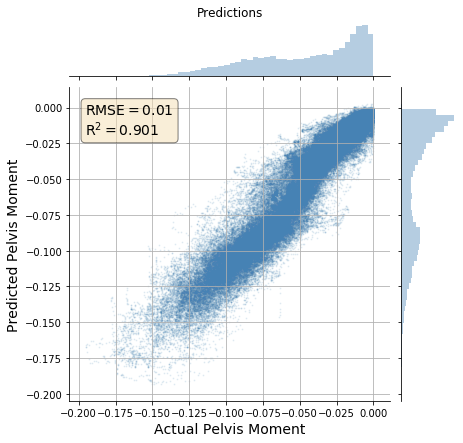

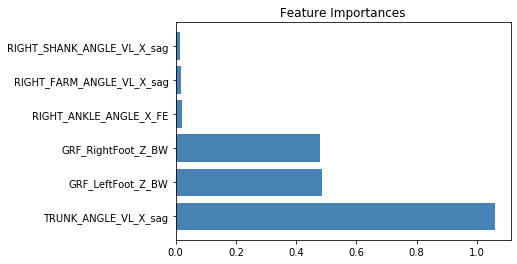

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.904**

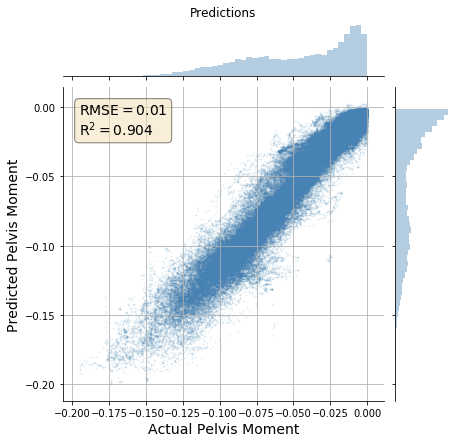

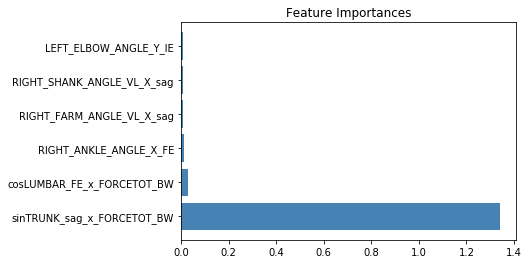

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.763**

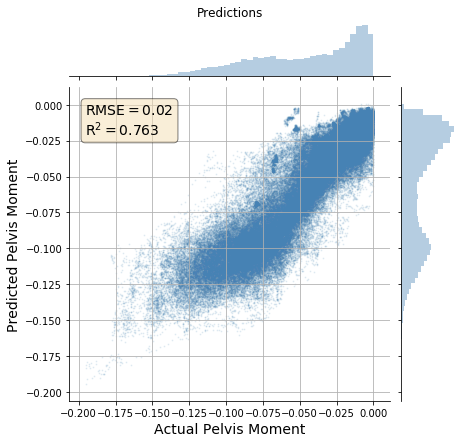

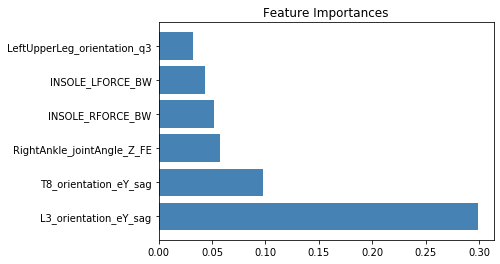

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.765**

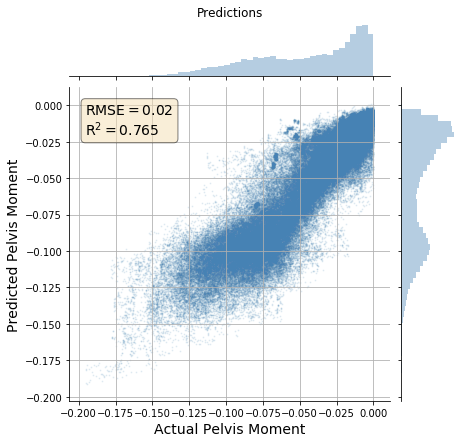

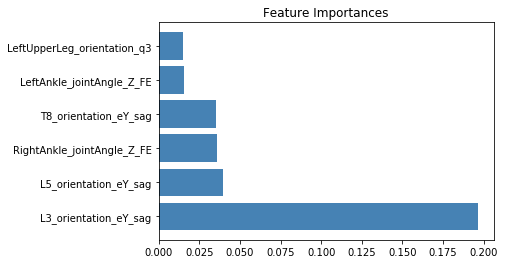

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=-1.086**

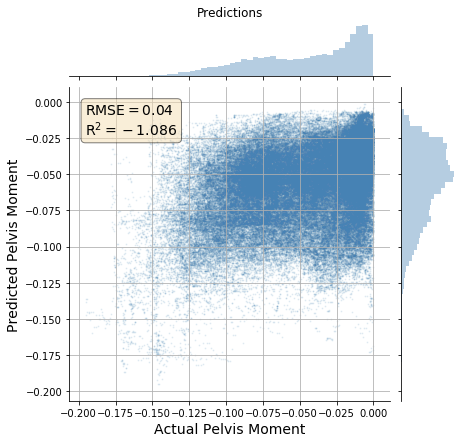

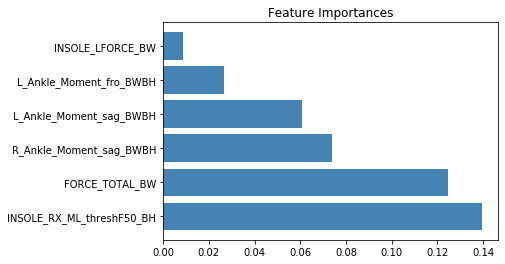

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.742**

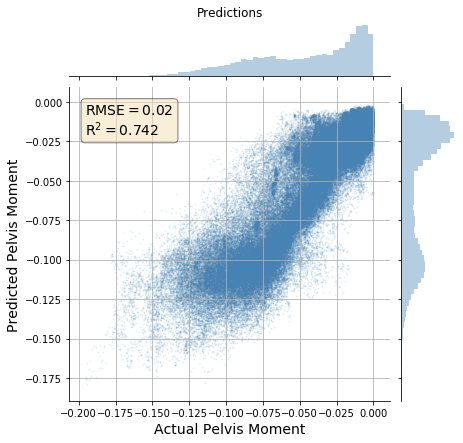

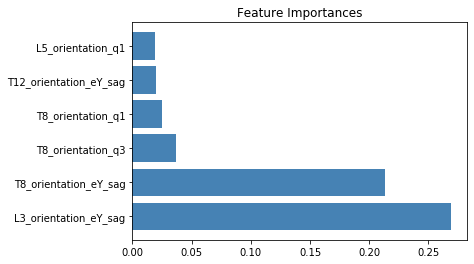

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.770**

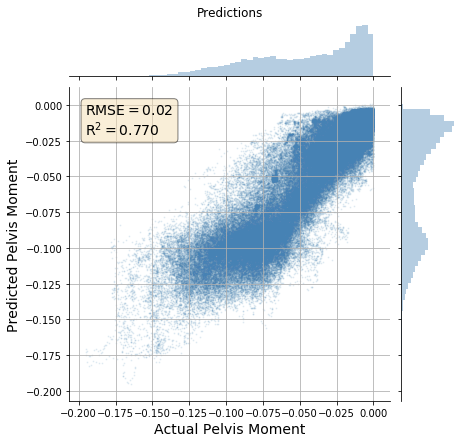

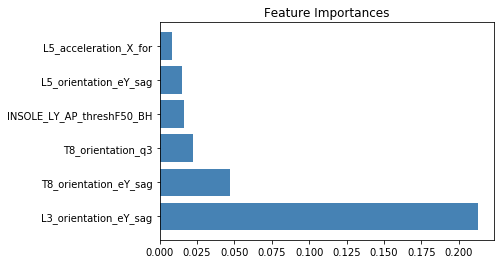

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.770**

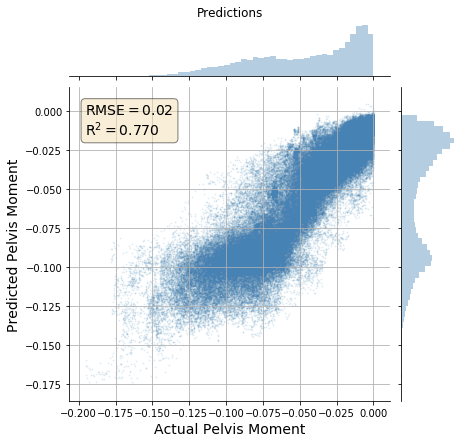

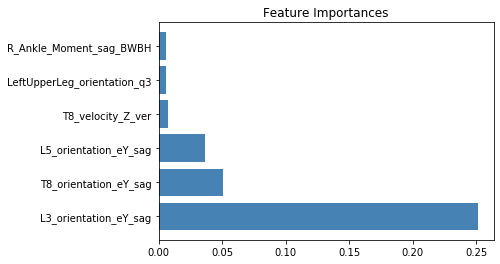

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.803**

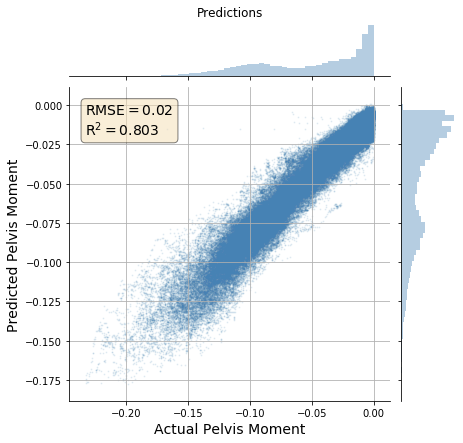

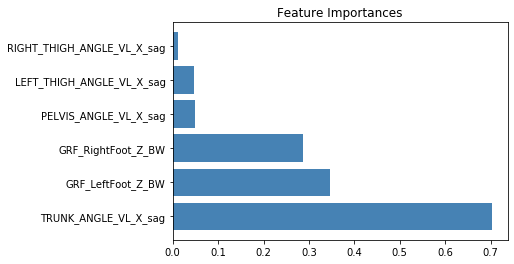

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.847**

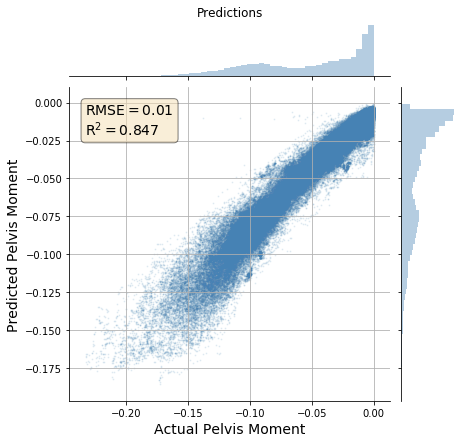

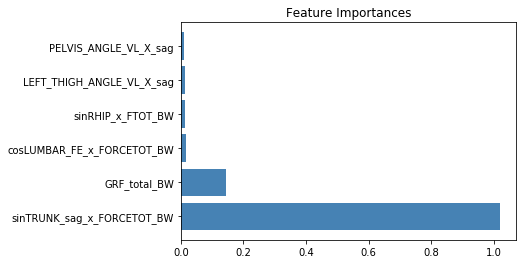

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.793**

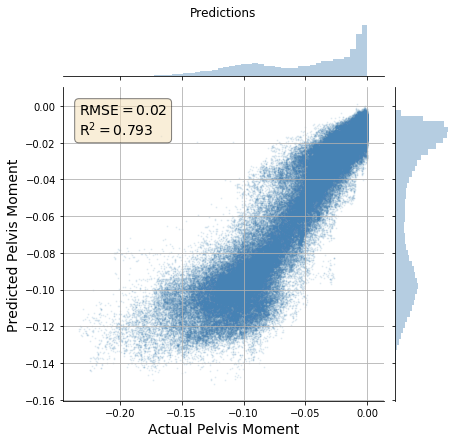

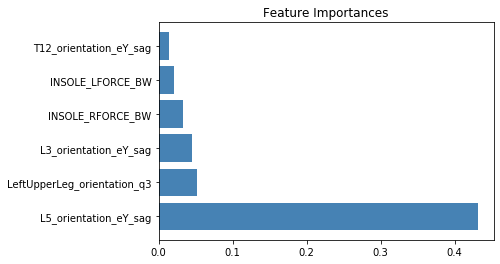

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.791**

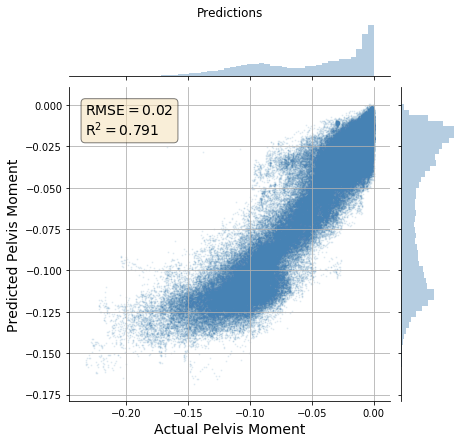

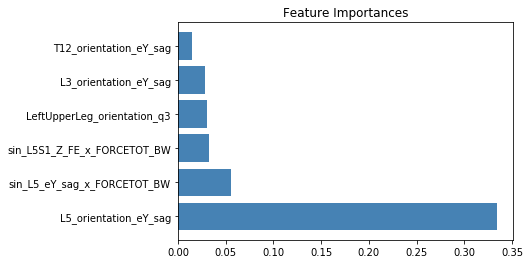

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=-2.562**

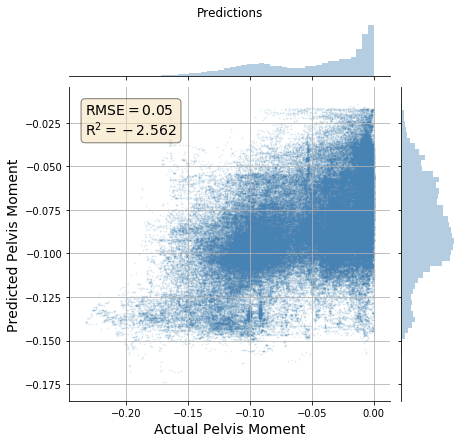

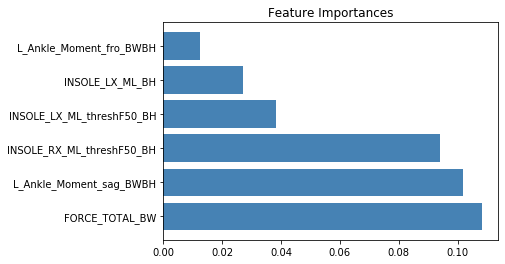

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.616**

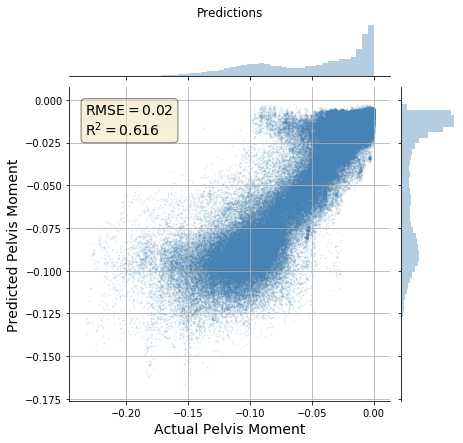

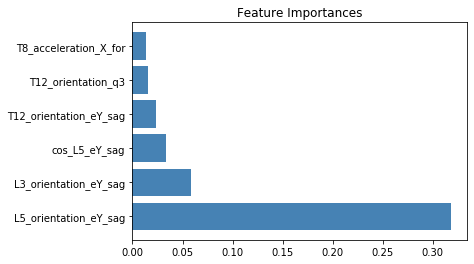

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.676**

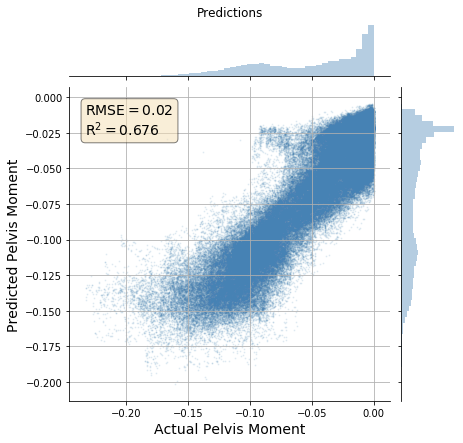

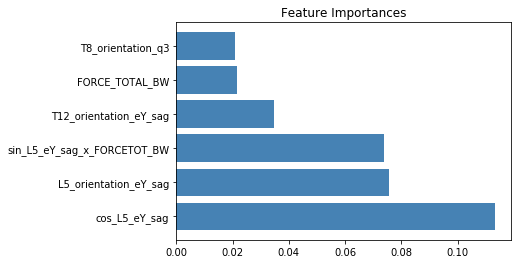

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.722**

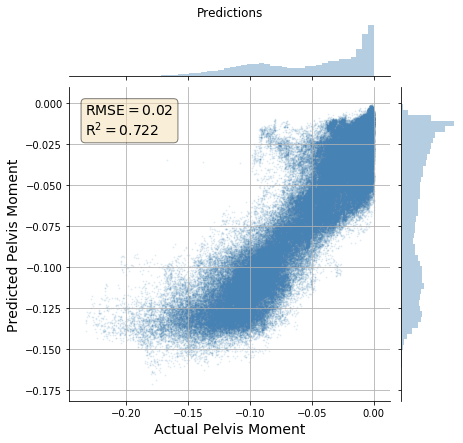

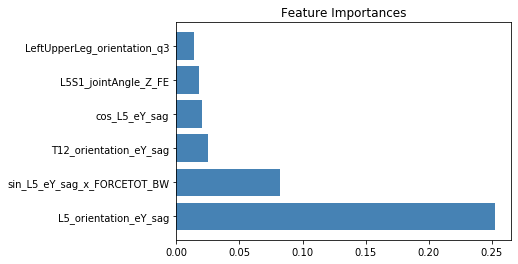

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.886**

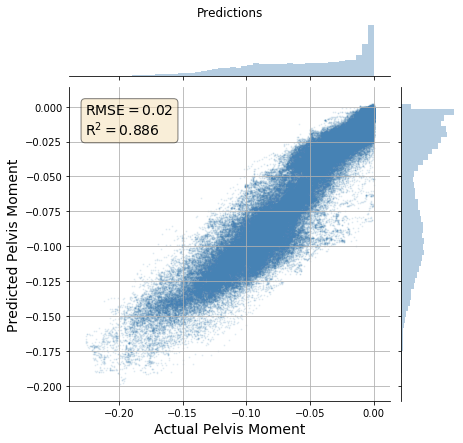

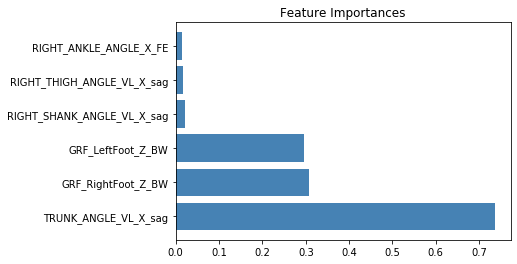

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.911**

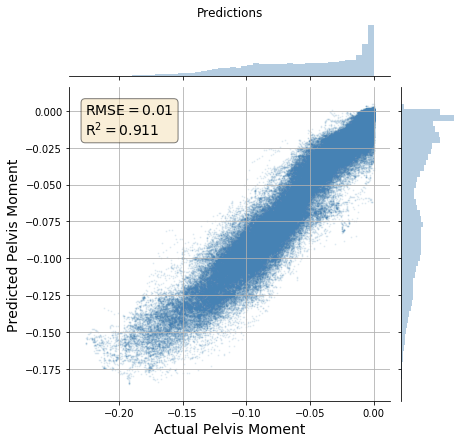

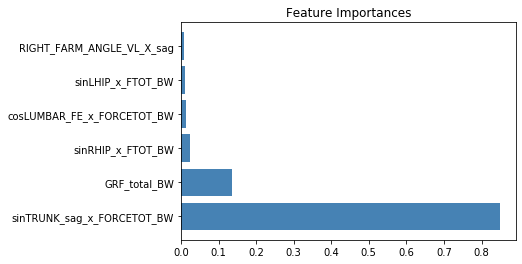

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.643**

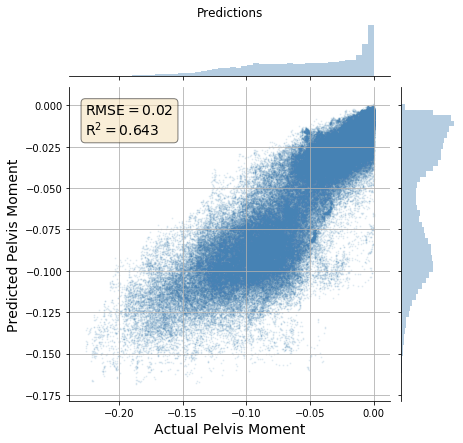

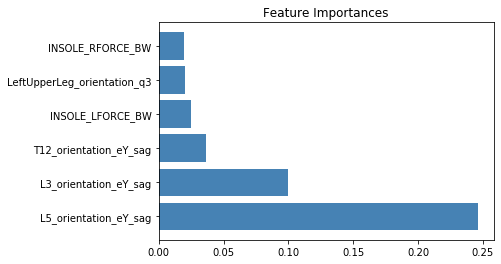

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.542**

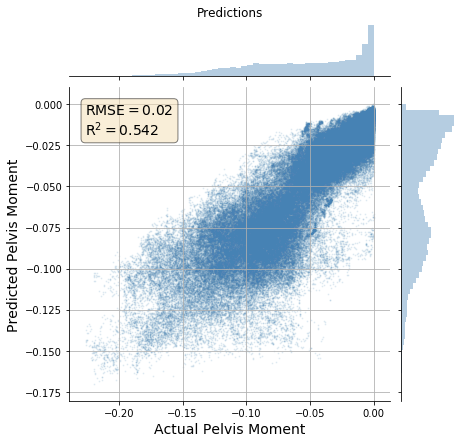

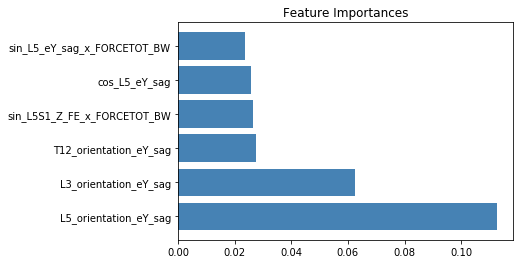

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=-2.674**

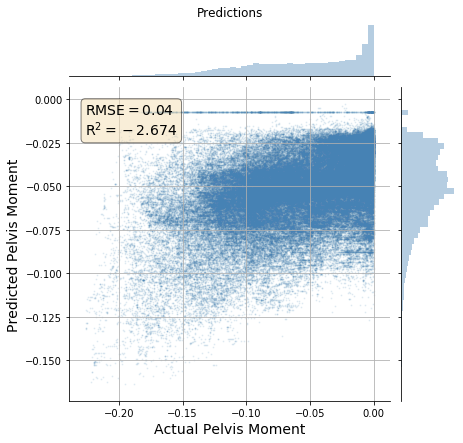

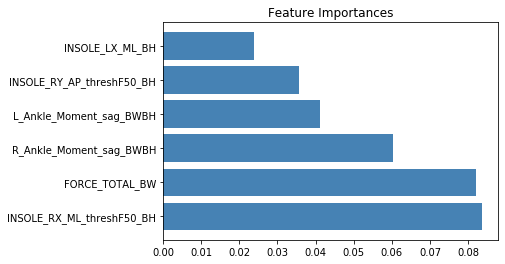

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.627**

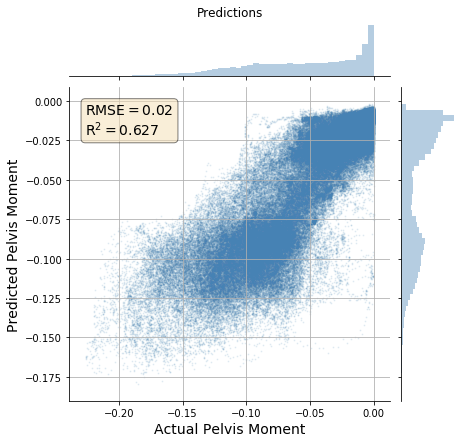

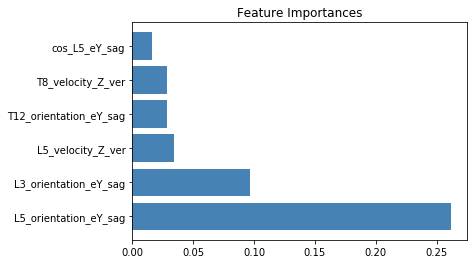

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.477**

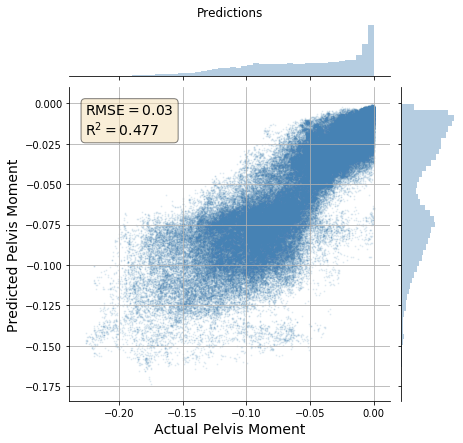

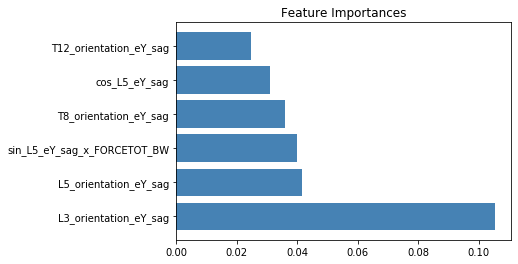

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.588**

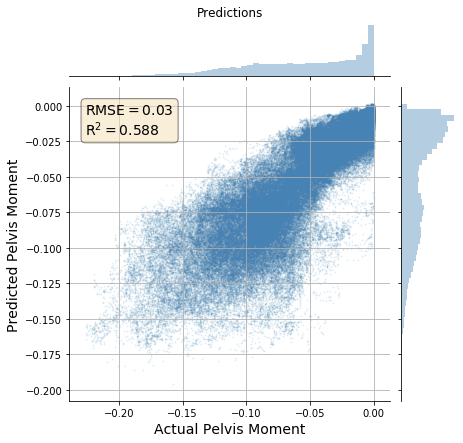

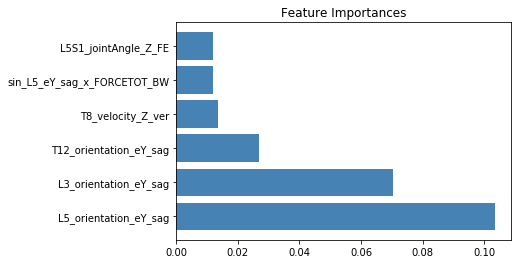

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.956**

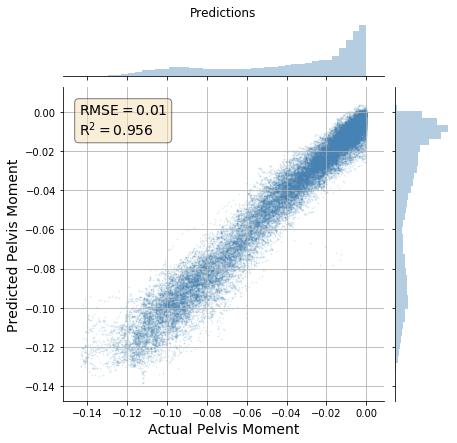

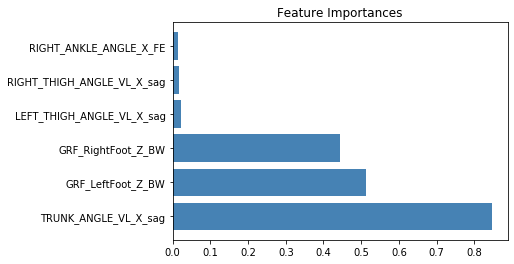

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.964**

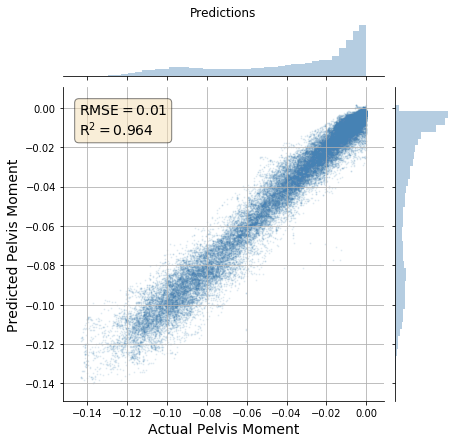

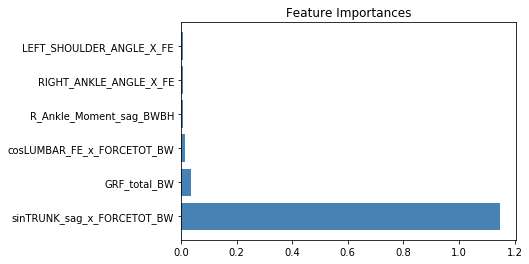

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.922**

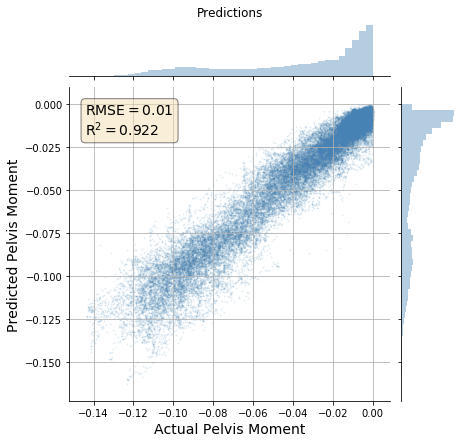

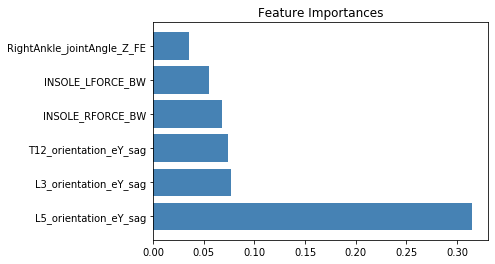

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.914**

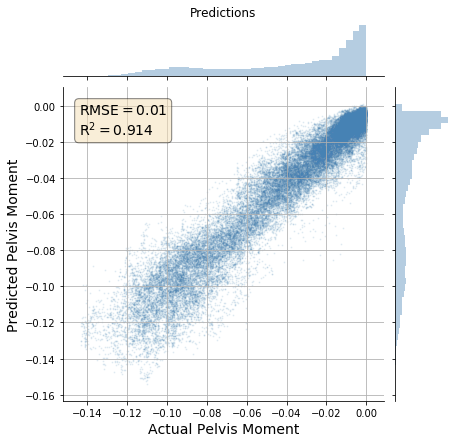

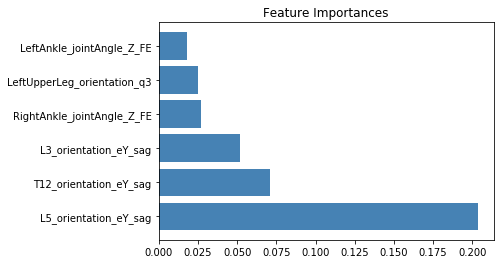

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=-0.584**

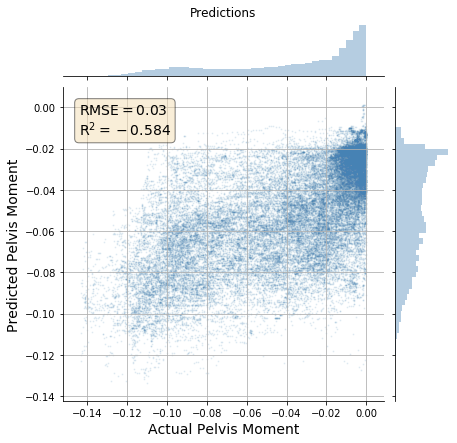

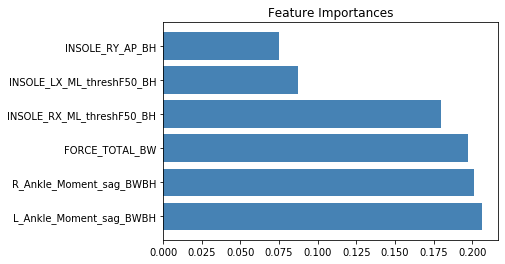

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.890**

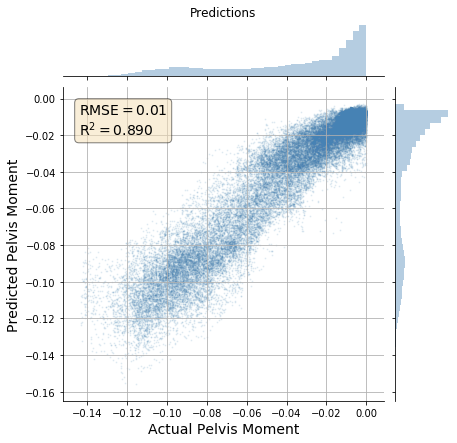

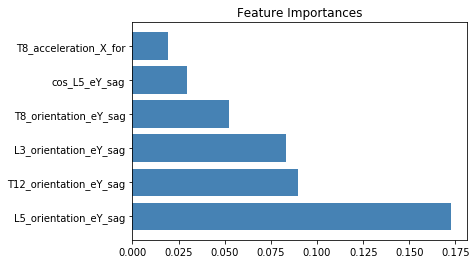

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.906**

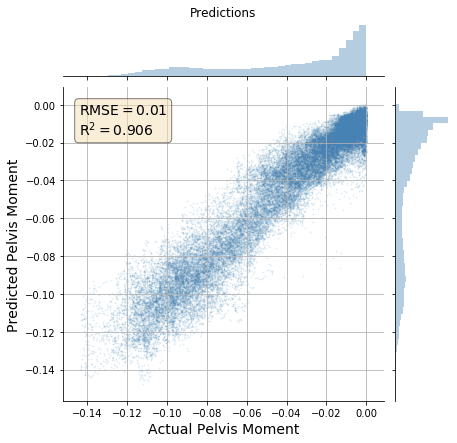

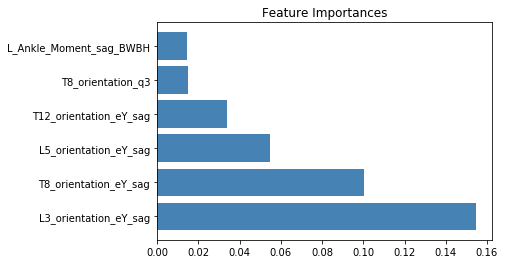

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.907**

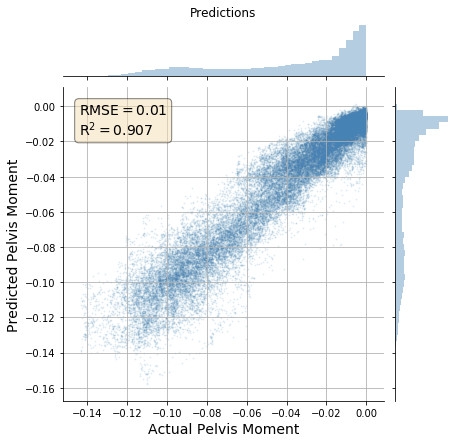

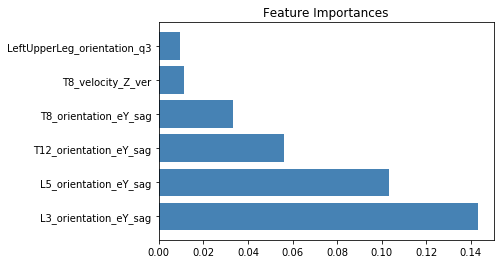

In [8]:
r2_scores_X, predictions_X = run_experiments("TF_Pelvis_Moment_X_BWBH", train_test_sets, color="steelblue")

## Estimating TF_Pelvis_Moment_Y_BWBH


---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.898**

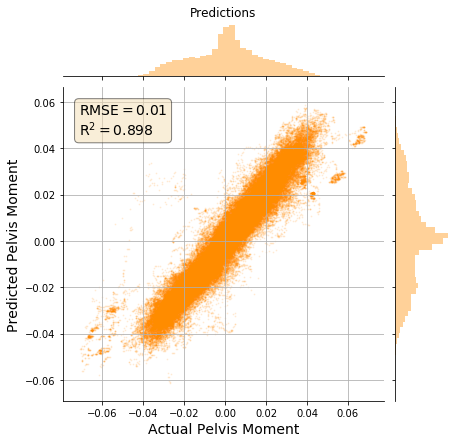

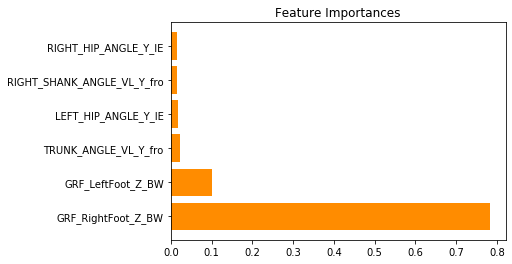

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.903**

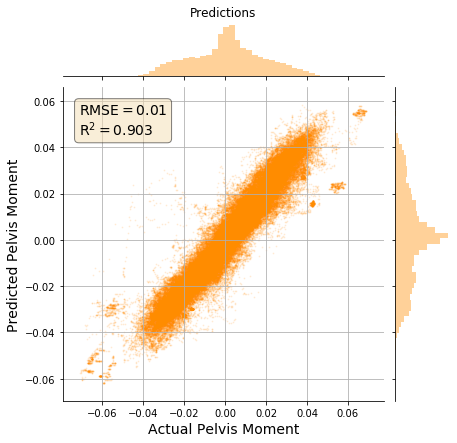

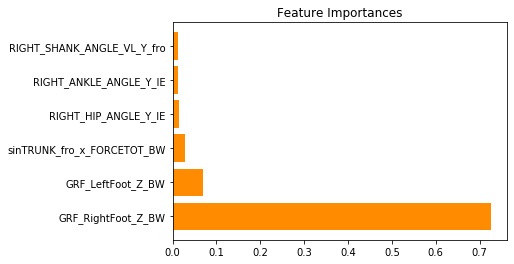

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.719**

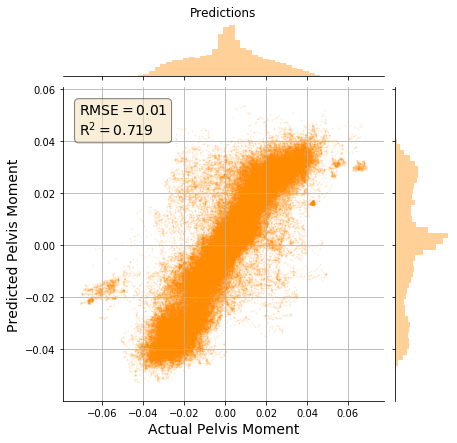

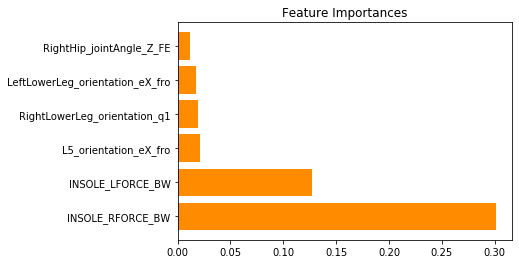

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.717**

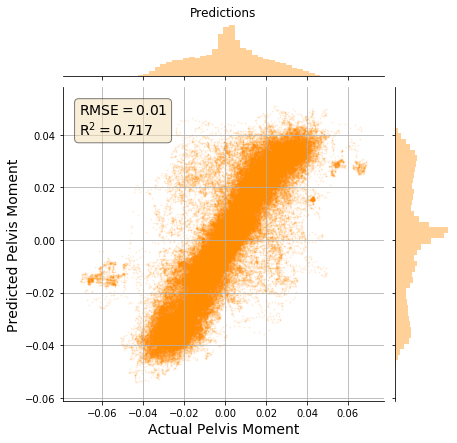

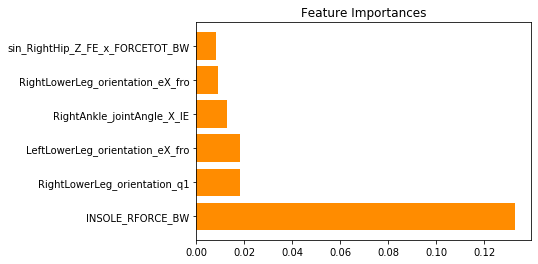

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.625**

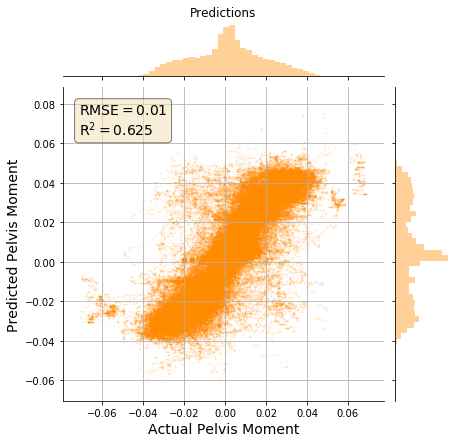

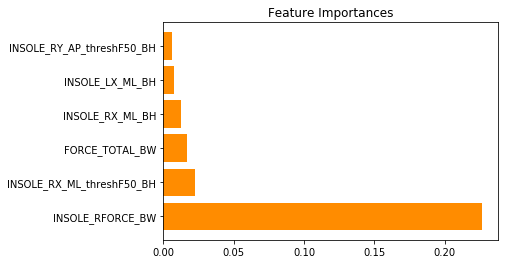

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.489**

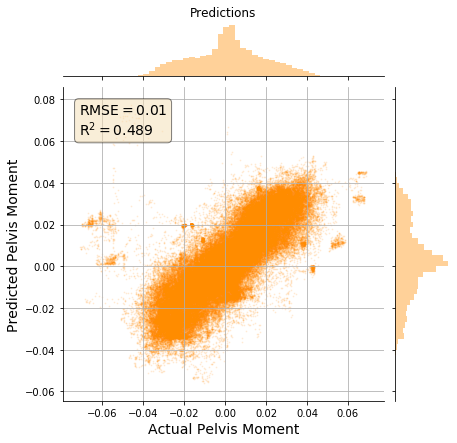

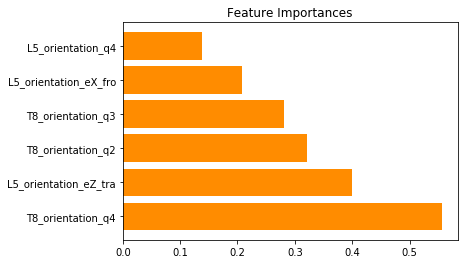

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.722**

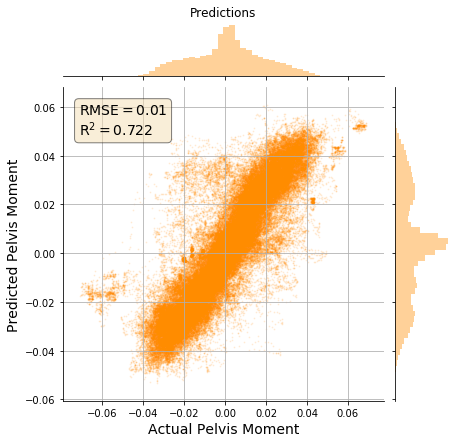

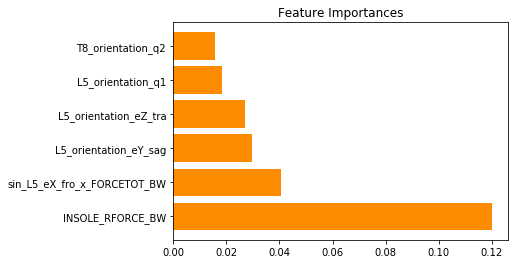

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 1 & 2 -> Subject 3  
**R2=0.721**

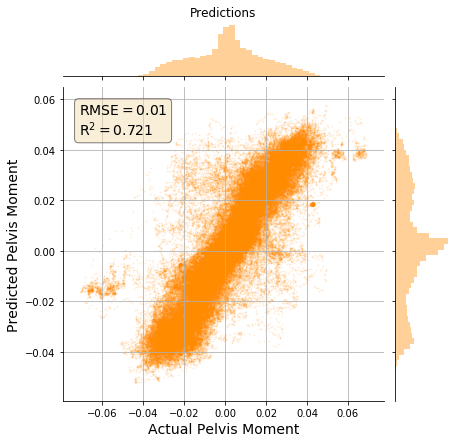

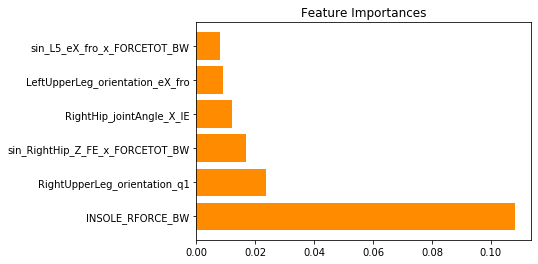

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.916**

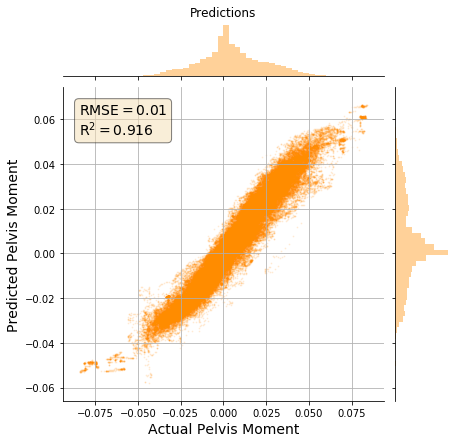

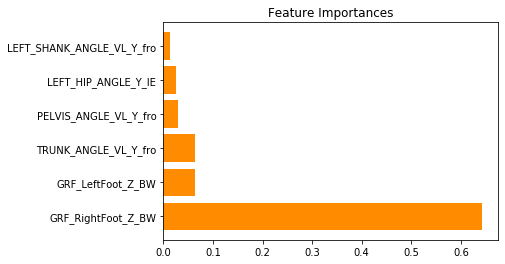

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.914**

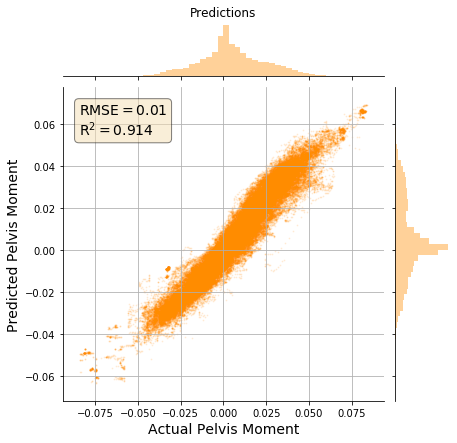

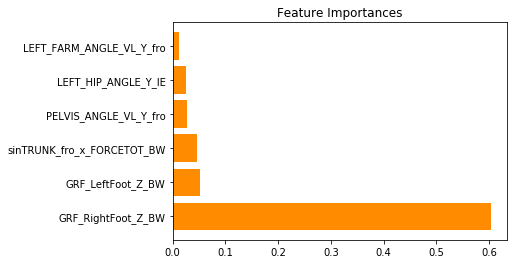

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.731**

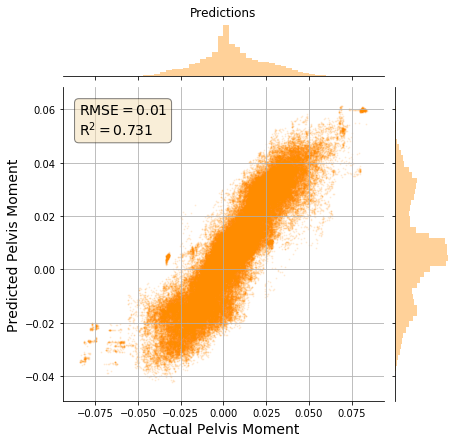

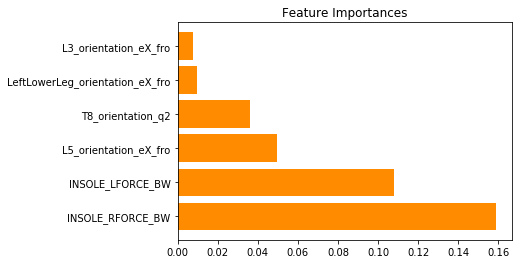

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.728**

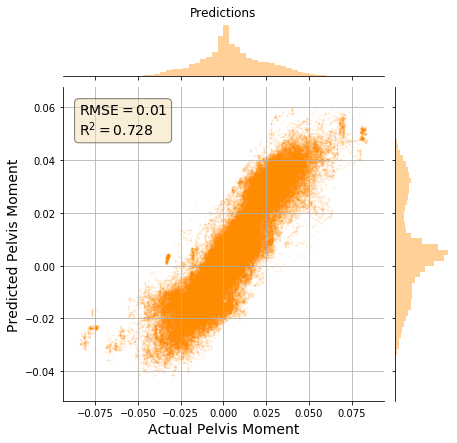

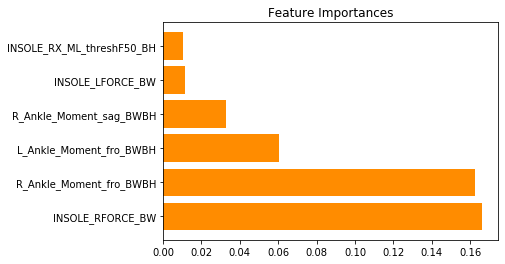

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.639**

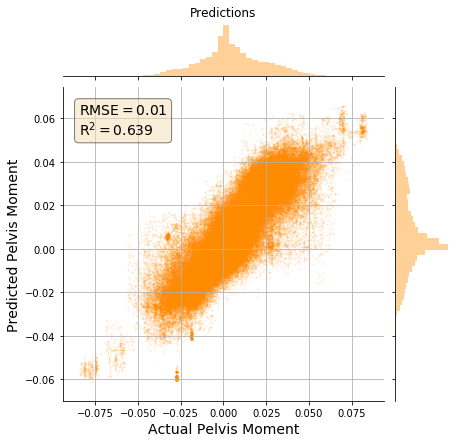

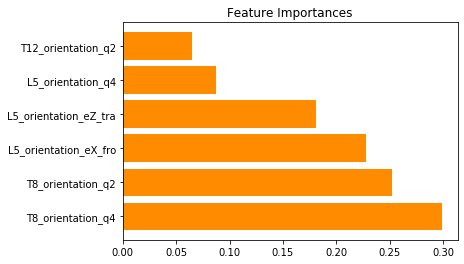

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.649**

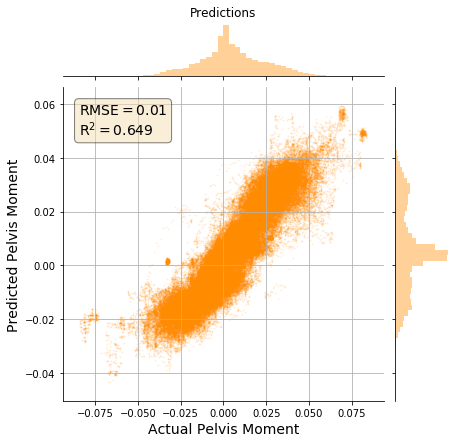

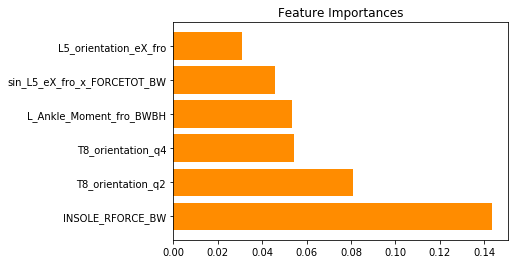

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 1 & 3 -> Subject 2  
**R2=0.632**

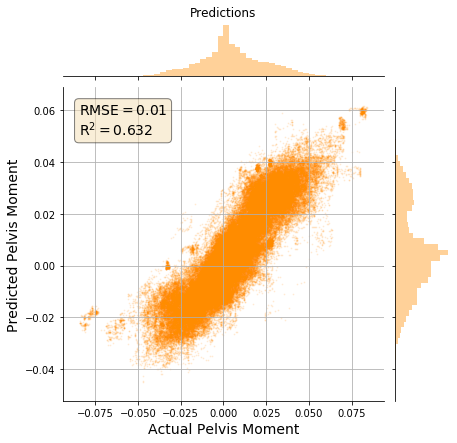

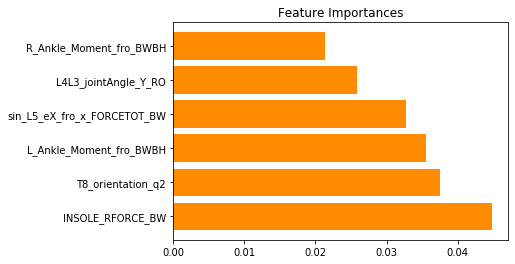

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.822**

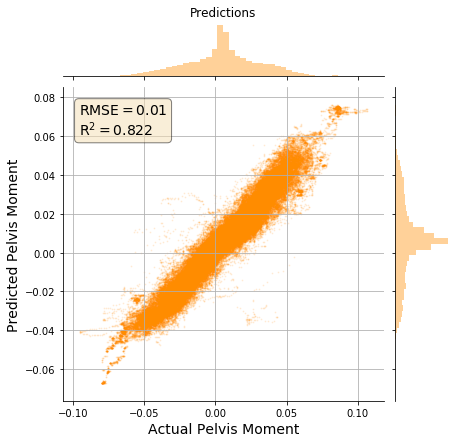

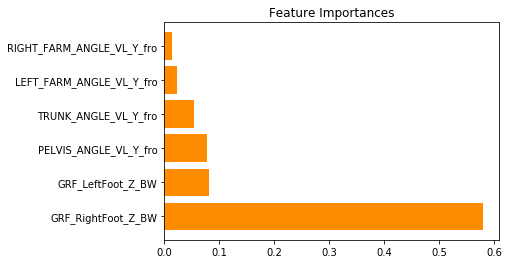

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.827**

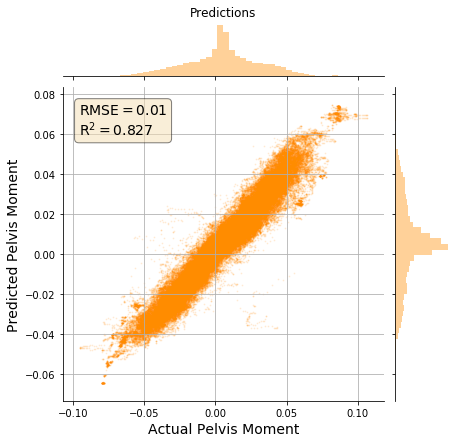

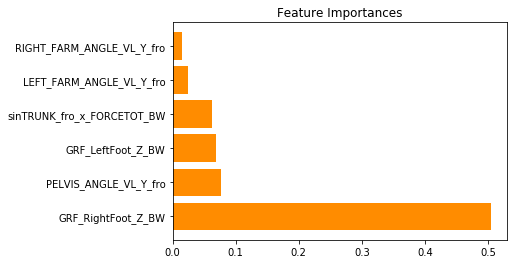

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.403**

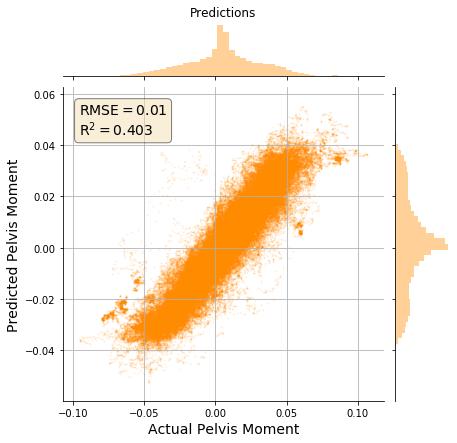

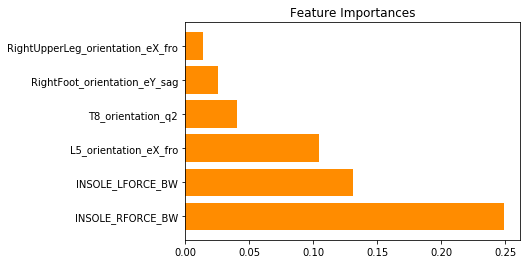

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.398**

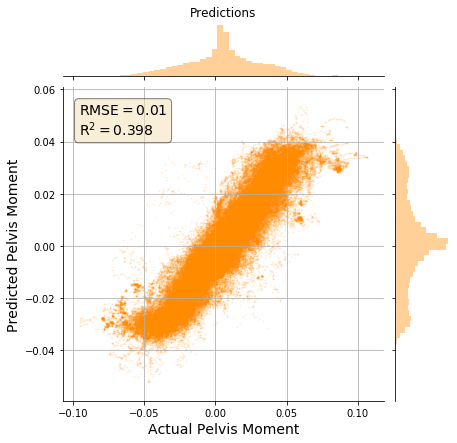

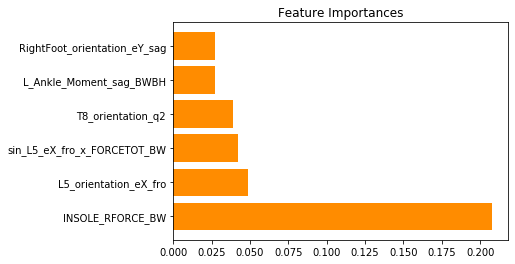

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=-0.084**

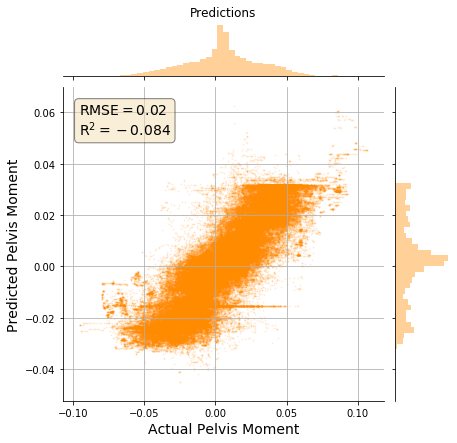

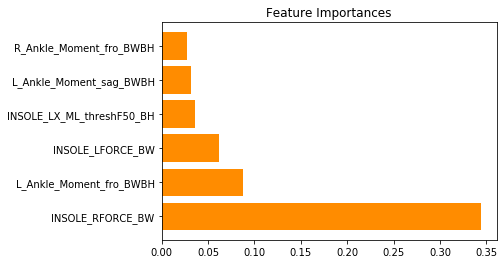

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.313**

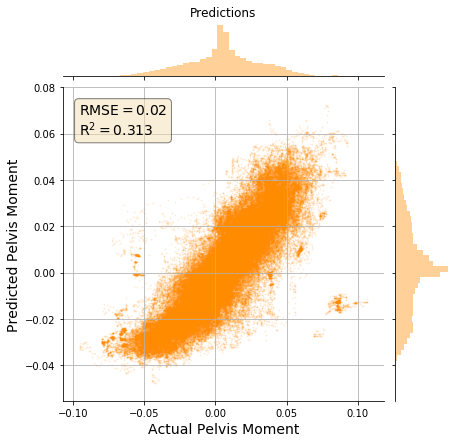

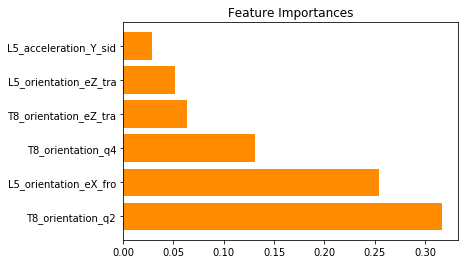

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.536**

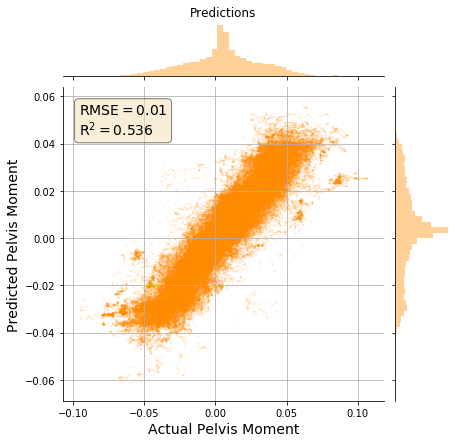

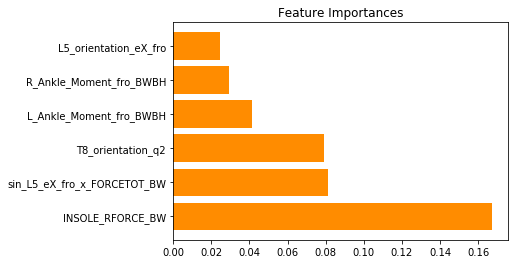

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 2 & 3 -> Subject 1  
**R2=0.372**

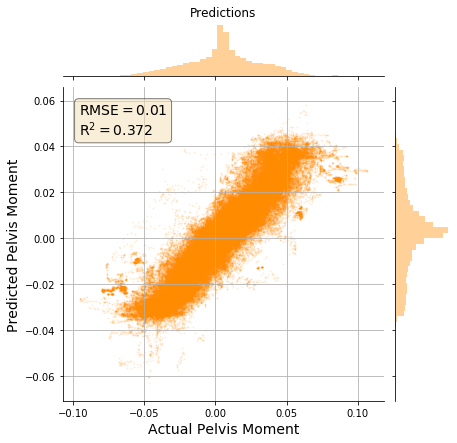

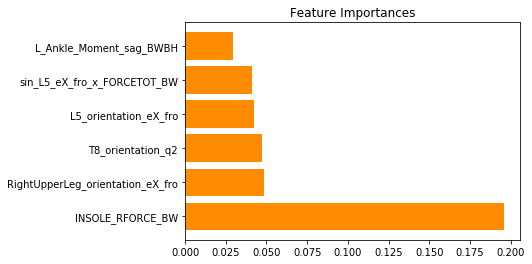

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.973**

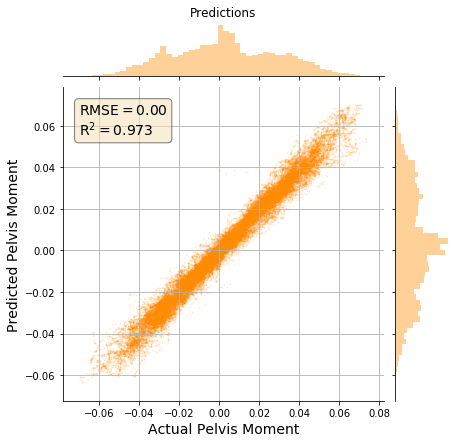

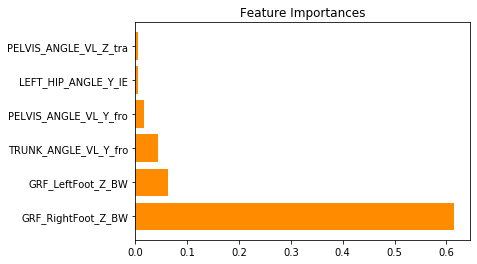

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.973**

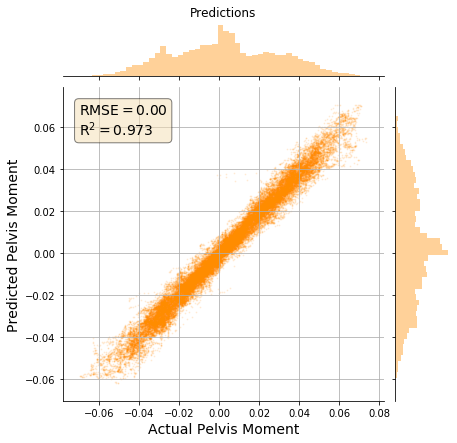

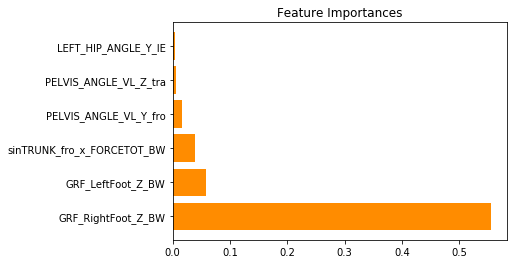

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.945**

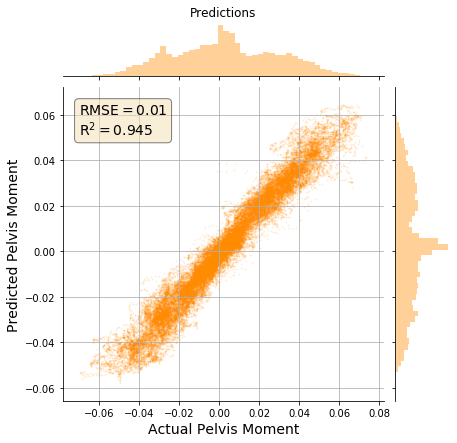

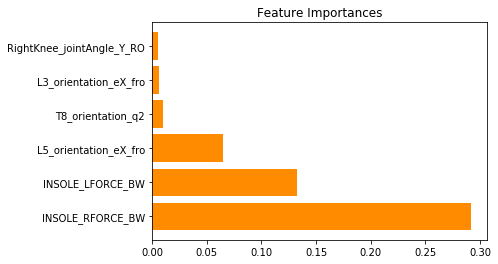

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.945**

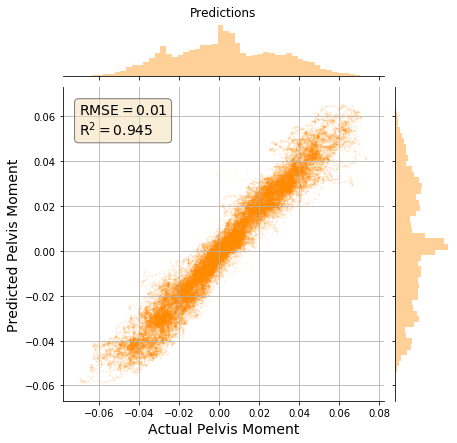

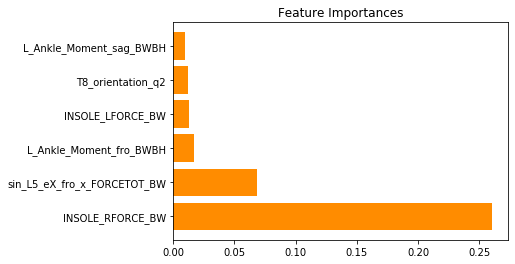

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.700**

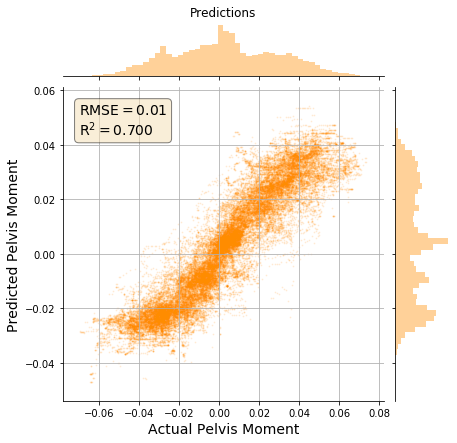

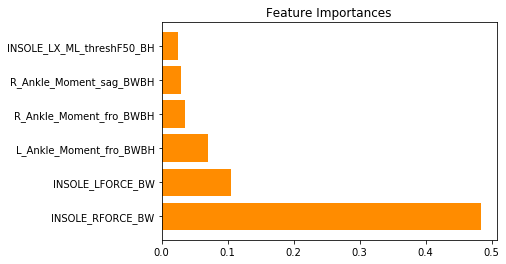

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.835**

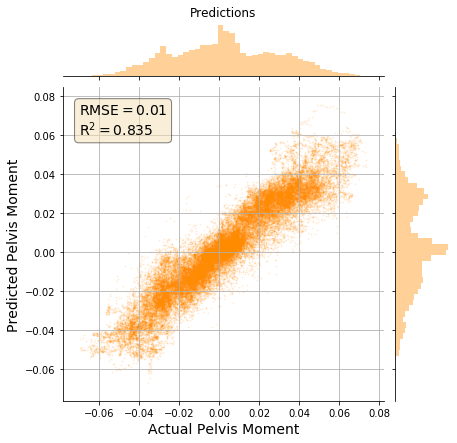

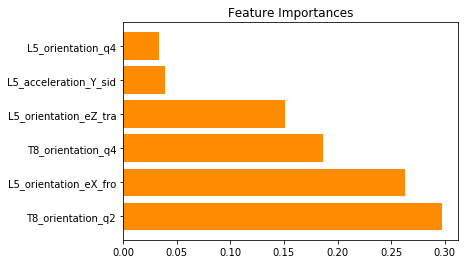

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.917**

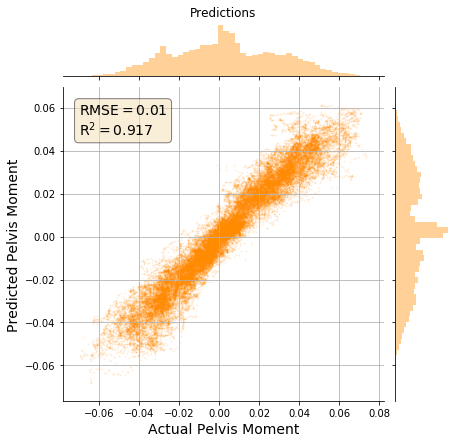

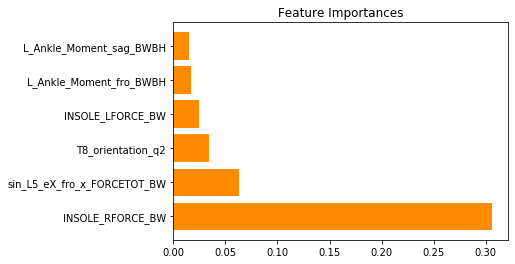

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 1 & 2 & 3 -> 5kg Test  
**R2=0.933**

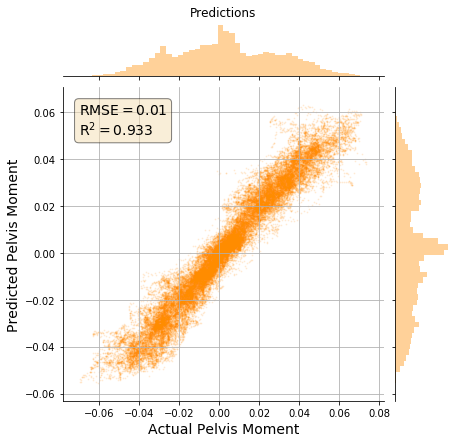

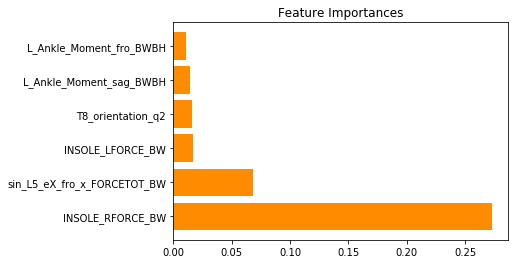

In [9]:
r2_scores_Y, predictions_Y = run_experiments("TF_Pelvis_Moment_Y_BWBH", train_test_sets, color="darkorange")

## Saving results

In [10]:
with pd.ExcelWriter('CPAC_S01_S02_S03_05_31_20 - Results.xlsx') as writer:
    pd.DataFrame(r2_scores_X).to_excel(writer, sheet_name='TF_Pelvis_Moment_X_BWBH')
    pd.DataFrame(r2_scores_Y).to_excel(writer, sheet_name='TF_Pelvis_Moment_Y_BWBH')

In [11]:
pred_df = df_orig[get_meta_names(df_orig) + ["TF_Pelvis_Moment_X_BWBH", "TF_Pelvis_Moment_Y_BWBH"]]

for feature_set in feature_sets:
    print(feature_set)
    merge_preds_X = predictions_X["Subject 1 & 2 -> Subject 3"][feature_set].append(
        predictions_X["Subject 2 & 3 -> Subject 1"][feature_set]).append(
        predictions_X["Subject 1 & 3 -> Subject 2"][feature_set])
    merge_preds_Y = predictions_Y["Subject 1 & 2 -> Subject 3"][feature_set].append(
        predictions_Y["Subject 2 & 3 -> Subject 1"][feature_set]).append(
        predictions_Y["Subject 1 & 3 -> Subject 2"][feature_set])
    kwargs = {
        feature_set[:8] + "_TF_Pelvis_Moment_X_BWBH": merge_preds_X,
        feature_set[:8] + "_TF_Pelvis_Moment_Y_BWBH": merge_preds_Y,
             }
    pred_df = pred_df.assign(**kwargs)
pred_df.to_csv(f"CPAC_S01_S02_S03_05_31_20 - Predictions.csv")


Recipe 1: Simulated Wearable - All Regular
Recipe 2: Simulated Wearable - All Regular & Exploratory
Recipe 3: Real Wearable - All Regular
Recipe 4: Real Wearable - All Regular & Exploratory
Recipe 5: Real Wearable - Insole Only
Recipe 6: Real Wearable - Trunk Orientatoin Only
Recipe 7: Real Wearable - Insole & Trunk Orientation
Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
